In [54]:
import os
import time
import sys
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.neighbors import NearestCentroid, kneighbors_graph
from sklearn import metrics
from sklearn.metrics import silhouette_score
from scipy.spatial.distance import cdist
from scipy.spatial import KDTree, cKDTree
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from concorde.tsp import TSPSolver
from math import sqrt, ceil, inf, floor

In [55]:
root_dir = os.getcwd()
tsp_dir = os.path.join(root_dir, "../tsplib")
print(tsp_dir)
concorde_dir = os.path.join(root_dir, "../pyconcorde/concorde")

/home/dynamo/a/yoo241/Project/Large-Scale-Ising/../tsplib


In [56]:
sys.path.insert(0, root_dir)
sys.path.insert(0, tsp_dir)
#sys.path.insert(0, concorde_dir)

In [57]:
num_samples = 10000

In [58]:
def gen_tsp_data():
    ## Load a tsp library and Create a dictionary "tsp_database" of Name-X/Y coordinates.

    tsp_database = {}
    cities = os.listdir(tsp_dir)
    
    for city in cities:
        if city.endswith(".tsp"):
            with open(tsp_dir + '/' + city, 'r') as infile:
                lines = infile.readlines()
                for i in range(0, len(lines)):
                    line = lines[i]
                    if "DIMENSION" in line:
                        Dimension = line.strip().split(':')[1]
                        if not Dimension.isdigit():
                            continue
                    if "EDGE_WEIGHT_TYPE" in line:
                        EdgeWeightType = line.strip().split()[1]
                        if EdgeWeightType != "EUC_2D":
                            continue
                    if "NODE_COORD_SECTION" in line:
                        x_y = None
                        nodelist_x = []
                        nodelist_y = []
        
                        for j in range (1, int(Dimension)):
                            x_y = lines[i+1].strip().split()[1:]
    #                        print(x_y)
    #                        import pdb; pdb.set_trace()
                            x = x_y[0]
                            y = x_y[1]
                            nodelist_x.append(float(x))
                            nodelist_y.append(float(y))
                            i+=1
                        tsp_database.update({city[:-4]:[nodelist_x, nodelist_y]})
    return tsp_database    

In [59]:
tsp_database = gen_tsp_data()
problem_list = tsp_database.keys()
problem_list

dict_keys(['pcb442', 'd15112', 'pla7397', 'd18512', 'd2103', 'fl1400', 'pr107', 'berlin52', 'fl3795', 'pcb3038', 'u1060', 'gr666', 'fnl4461', 'gil262', 'kroB200', 'kroE100', 'pr2392', 'lin318', 'pla85900', 'usa13509', 'brd14051', 'pla33810', 'pr152', 'pr226', 'pr1002', 'u2152', 'eil76', 'rl5934', 'bier127', 'rl5915', 'u2319', 'rat783', 'rl11849', 'rat575', 'kroA100', 'eil101'])

In [60]:
cluster_size_min = 3
cluster_size_max = 18

if cluster_size_max == 12:
    cluster_dict = {
        "berlin52": [9],
        "eil76": [9],
        "eil101": [21,3],
        "kroE100": [14,2],
        "kroB200": [33,5],
        "gil262": [41,4],
        "lin318": [56,6],
        "pcb442": [79,10],
        "rat575": [73,9],
        "gr666": [335,52,7],
        "rat783": [113,14,2],
        "pr1002": [161,21,2],
        "u1060": [273, 45, 6],
        "d2103": [288,42,6],
        "u2152": [365,50,6],
        "pr2392": [416,55,6],
        "pcb3038": [487,75,8],
        "fnl4461": [773,125,16,2],
        "rl5915": [980,139,17,2],
        "rl5934": [1237,196,29,4],
        "rl11849": [2341,375,61,7],
        "d18512": [6215, 1221, 180, 20, 3],
        "pla33810": [6446,1257,192,28,3],
        "pla85900": [16355, 3024, 486, 68, 9]
        }
elif cluster_size_max == 14:
    cluster_dict = {
        "berlin52": [9],
        "eil76": [9],
        "eil101": [21, 2],
        "kroE100": [14],
        "kroB200": [28, 2],
        "gil262": [38, 4],
        "lin318": [56, 5],
        "pcb442": [62, 7],
        "rat575": [73, 7],
        "gr666": [335, 52, 7],
        "rat783": [113, 12],
        "pr1002": [145, 18, 2],
        "u1060": [273, 35, 4],
        "d2103": [236, 31, 4],
        "u2152": [365, 45, 5],
        "pr2392": [329, 42, 4],
        "pcb3038": [487, 58, 7],
        "fnl4461": [594, 66, 8],
        "rl5915": [901, 130, 15, 2],
        "rl5934": [985, 147, 17, 2],
        "rl11849": [1842, 227, 24, 2],
        "d18512": [6215, 1059, 143, 13],
        "pla33810": [5156, 851, 104, 13],
        "pla85900": [13790, 2154, 302, 35, 4]
        }
elif cluster_size_max == 16:
    cluster_dict = {
        "berlin52": [9],
        "eil76": [9],
        "eil101": [10],
        "kroE100": [10],
        "kroB200": [28, 2],
        "gil262": [25, 2],
        "lin318": [37, 3],
        "pcb442": [49, 4],
        "rat575": [56, 6],
        "gr666": [203, 34, 4],
        "rat783": [89, 8],
        "pr1002": [145, 15],
        "u1060": [273, 33, 3],
        "d2103": [231, 23, 2],
        "u2152": [260, 22, 2],
        "pr2392": [329, 38, 4],
        "pcb3038": [438, 54, 6],
        "fnl4461": [547, 68, 7],
        "rl5915": [834, 91, 10],
        "rl5934": [778, 89, 9],
        "rl11849": [1709, 199, 18, 2],
        "d18512": [4538, 538, 68, 6],
        "pla33810": [4364, 698, 69, 7],
        "pla85900": [11962, 1503, 186, 19, 2]
        }
elif cluster_size_max == 18:
    cluster_dict = {
        "berlin52": [9],
        "eil76": [6],
        "eil101": [10],
        "kroE100": [8],
        "kroB200": [18],
        "gil262": [25, 2],
        "lin318": [37, 3],
        "pcb442": [44, 5],
        "rat575": [53, 4],
        "gr666": [203, 34, 3],
        "rat783": [69, 6],
        "pr1002": [98, 11],
        "u1060": [273, 23, 2],
        "d2103": [223, 18],
        "u2152": [253, 22, 2],
        "pr2392": [248, 19, 2],
        "pcb3038": [391, 35, 3],
        "fnl4461": [503, 46, 4],
        "rl5915": [834, 78, 7],
        "rl5934": [673, 71, 6],
        "rl11849": [1428, 165, 14],
        "d18512": [3582, 338, 33, 3],
        "pla33810": [4132, 566, 50, 4],
        "pla85900": [10104, 1239, 121, 11]
        }
elif cluster_size_max == 20:
    cluster_dict = {
        "berlin52": [9],
        "eil76": [6],
        "eil101": [10],
        "kroE100": [7],
        "kroB200": [14],
        "gil262": [24, 2],
        "lin318": [37, 3],
        "pcb442": [32, 3],
        "rat575": [43, 3],
        "gr666": [203, 34, 3],
        "rat783": [69, 4],
        "pr1002": [98, 7],
        "u1060": [273, 23, 2],
        "d2103": [217, 17],
        "u2152": [253, 19],
        "pr2392": [208, 16],
        "pcb3038": [324, 26, 2],
        "fnl4461": [450, 35, 2],
        "rl5915": [610, 57, 4],
        "rl5934": [618, 51, 3],
        "rl11849": [1319, 112, 10],
        "pla33810": [3582, 338, 33, 3],
        "pla33810": [3454, 305, 24, 2],#for 23, should be <3000 for 22 3300~3400
        "pla85900": [9566, 1100, 94, 8]#for 22, should be <9000
        }
elif cluster_size_max == 10:
    cluster_dict = {
        "berlin52": [12, 2],
        "eil76": [13, 2],
        "eil101": [21, 3],
        "kroE100": [18, 2],
        "kroB200": [33, 5],
        "gil262": [43, 7],
        "lin318": [65, 10],
        "pcb442": [87, 12, 2],
        "rat575": [89, 13, 2],
        "gr666": [335, 88, 18, 3],
        "rat783": [126, 20, 3],
        "pr1002": [247, 39, 5],
        "d2103": [290, 57, 10],
        "u2152": [406, 65, 10],
        "pr2392": [464, 86, 15, 2],
        "pcb3038": [633, 127, 19, 3],
        "fnl4461": [851, 141, 22, 3],
        "rl5915": [1286, 234, 39, 5],
        "rl5934": [1264, 272, 46, 8],
        "rl11849": [2793, 556, 99, 16, 3],
        "pla33810": [7215, 1562, 257, 52, 8],#for 23, should be <3000 for 22 3300~3400
        "pla85900": []#for 22, should be <9000
        }

Problem : d18512


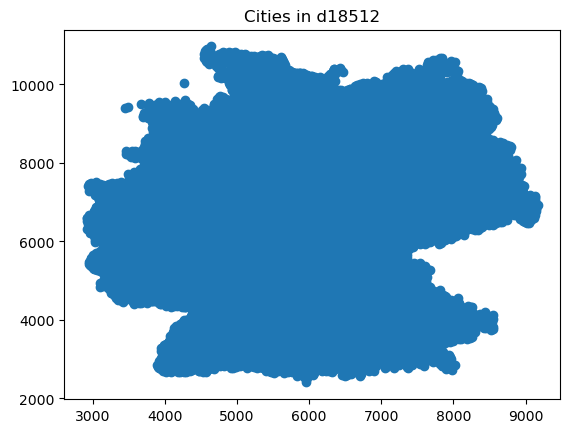

In [61]:
import pyproj as p

x = "d18512"
n_clusters = cluster_dict[x]
coord_geo = False
if coord_geo == True:
     crs_wgs = p.Proj(init='epsg:4326')
     crs_bng = p.Proj(init = 'epsg:27700')
    
     tsp_database[x][0],tsp_database[x][1]  = p.transform(crs_wgs, crs_bng, tsp_database[x][1], tsp_database[x][0])
# for x in tsp_database:
print("Problem : " + x)
#    print(tsp_database[x])
X_coord = np.array(tsp_database[x][0])
Y_coord = np.array(tsp_database[x][1])
X_Y = np.array(list(zip(X_coord,Y_coord))).reshape(len(X_coord),2)
plt.plot()
plt.title('Cities in ' + x)
plt.scatter(X_coord, Y_coord)
plt.show()


lt.plot()<br>
lt.title('Cities in ' + x)<br>
lt.scatter(X_coord, Y_coord)<br>
lt.show()

In [62]:
from numpy import inf

X_Y[X_Y == inf] = 0


In [63]:
def get_clustered_cities(num_clust, labels_array):
    return np.where(labels_array == num_clust)

In [64]:
def plot_sys2_cities(sys2_cities):
    for k in K:
        plt.scatter(sys2_cities[k][:,0], sys2_cities[k][:,1])
        plt.show()

In [65]:

import time   
from k_means_constrained import KMeansConstrained

X_Y=[X_Y]
KM_labels = []
i = 0

Contrained = False
## 0: K-means++ // 1: Agglomerative
Clustering_Methods = 1

hierarchies = []

CEs = []
clf = NearestCentroid()
SEARCH = True
if SEARCH:
    #n_clusters = floor(len(X_Y[i])/cluster_size_max)
    n_clusters = 3582
    Cluster_distribution = []
    while True:
        if Contrained:
            KMC = KMeansConstrained(
                n_clusters = n_clusters,
                size_min = cluster_size_min,
                size_max = cluster_size_max,
                random_state = 0)
            y_KMC = KMC.fit_predict(X_Y[i])
            centers = KMC.cluster_centers_
        elif Clustering_Methods == 0:
            kmeanModel = KMeans(n_clusters, init='k-means++', n_init=10).fit(X_Y[i])
            y_KMC = kmeanModel.labels_
            centers = kmeanModel.cluster_centers_
        else:
            tic = time.perf_counter()
            #knn_graph = kneighbors_graph(X_Y[i], n_clusters, include_self=False)
            #AggloModel = AgglomerativeClustering(n_clusters, metric='euclidean', connectivity= knn_graph, linkage='complete').fit(X_Y[i])
            #AggloModel = AgglomerativeClustering(n_clusters, metric='euclidean', connectivity= knn_graph, linkage='ward').fit(X_Y[i])
            #AggloModel = AgglomerativeClustering(n_clusters, metric='euclidean', linkage='complete').fit(X_Y[i])
            AggloModel = AgglomerativeClustering(n_clusters, metric='euclidean', linkage='ward').fit(X_Y[i])
            toc = time.perf_counter()
            #print(toc-tic)
            y_KMC = AggloModel.labels_
            clf.fit(X_Y[i], y_KMC)
            centers = clf.centroids_
        ICC = 0
        ICS = 0
        n_max = 0
        n_min = inf
        for c in range(len(centers)):
            center = centers[c]
            cities = np.where(y_KMC==c)[0]
            if len(cities) < n_min:
                n_min = len(cities)
            if len(cities) > n_max:
                n_max = len(cities)
            for city in cities:
                ICC += sqrt((X_Y[i][city][0]-center[0])**2+(X_Y[i][city][1]-center[1])**2)
            if len(cities) >1 :
                ICS += ICC/len(cities)
            ICC = 0
            #for center2 in centers:
            #    ICS += sqrt((center[0]-center2[0])**2+(center[1]-center2[1])**2)
        #CE = ICC/ICS
        CE = ICS/len(centers)
        CEs.append(CE)
        #Score = silhouette_score(X_Y[i], y_KMC)
        if len(CEs) > 10:
            MEAN = sum(CEs[-9:])/10
        else:
            MEAN = sum(CEs)/len(CEs)
        print(n_clusters, n_min, n_max, CE, MEAN)
        
        if (n_max < cluster_size_max+1):# and (n_clusters == 2 or MEAN*0.999 < CE):# and (MinScore*1.01 > Score):
            print(toc-tic)
            #plt.plot(range(len(CEs)), CEs, 'r-')
            #plt.show()
            colors = mpl.cm.tab20(range(20))
            c_labels = []
            for yy in y_KMC:
                c_labels.append(colors[yy%20])
            #plt.scatter(X_Y[i][:,0], X_Y[i][:,1], c=y_KMC, s=10, cmap='viridis')
            #plt.scatter(X_Y[i][:,0], X_Y[i][:,1], c=c_labels, s=10)
            #plt.scatter(centers[:,0], centers[:,1], c='black', s=50, alpha=0.5)
            #plt.rcParams.update({'font.size':15})
            #plt.show()
            
            #####
            unique, counts = np.unique(y_KMC, return_counts=True)
            unique, counts = np.unique(counts, return_counts=True)
            Cluster_distribution.append(dict(zip(unique, counts)))
            #####
            
            KM_labels.append(y_KMC)
            X_Y.append(centers)
            hierarchies.append(len(centers))
            i += 1
            if len(hierarchies) == 1:
                n_clusters = 338
            else:
                n_clusters = floor(len(X_Y[i])/cluster_size_max)
            if n_clusters < 2:
                n_clusters = 2
            if len(centers) < cluster_size_max+1:
                break
            CEs = []
        else:
            if len(hierarchies) == 0:
                n_clusters += 1
            else:
                n_clusters += 1

    Cluster_distribution.append(dict(zip([hierarchies[-1]], [1])))
    print(hierarchies)
    print(Cluster_distribution)
else:
    Cluster_distribution = []
    total_time = 0
    for N_C in n_clusters:
        
        tic = time.perf_counter()
        #knn_graph = kneighbors_graph(X_Y[i], n_clusters, include_self=False)
        #AggloModel = AgglomerativeClustering(n_clusters, metric='euclidean', connectivity= knn_graph, linkage='complete').fit(X_Y[i])
        #AggloModel = AgglomerativeClustering(n_clusters, metric='euclidean', connectivity= knn_graph, linkage='ward').fit(X_Y[i])
        #AggloModel = AgglomerativeClustering(n_clusters, metric='euclidean', linkage='complete').fit(X_Y[i])
        AggloModel = AgglomerativeClustering(N_C, metric='euclidean', linkage='ward').fit(X_Y[-1])
        toc = time.perf_counter()
        print(toc-tic)
        total_time += toc-tic
        y_KMC = AggloModel.labels_
        clf.fit(X_Y[-1], y_KMC)
        centers = clf.centroids_
        
        #####
        unique, counts = np.unique(y_KMC, return_counts=True)
        unique, counts = np.unique(counts, return_counts=True)
        Cluster_distribution.append(dict(zip(unique, counts)))
        #####
        
        KM_labels.append(y_KMC)
        X_Y.append(centers)
        hierarchies.append(len(centers))
        
    Cluster_distribution.append(dict(zip([hierarchies[-1]], [1])))
    print(hierarchies)
    print(Cluster_distribution)
    print("total time for clustering: ", total_time)

3582 1 18 30.39686685818422 30.39686685818422
6.740645531564951
338 1 18 122.31996873533642 122.31996873533642
0.2576966853812337
18 10 26 562.1347770279406 562.1347770279406
19 10 26 544.2484555361267 553.1916162820337
20 10 25 529.3895561658082 545.2575962432919
21 10 25 515.6896484876237 537.8656093043749
22 8 25 495.26179825663445 529.3448470948267
23 8 25 485.10771205748705 521.9719912552702
24 8 21 474.93652799012244 515.2526393602491
25 8 21 463.0859027329089 508.7317972818315
26 7 21 451.15342598074244 502.3342004705994
27 7 21 443.2022778292207 496.42100820646147
28 6 21 430.8324724596818 428.865932196023
29 6 21 425.8134302943749 418.5083196088796
30 6 21 418.44163533872256 408.7835182939895
31 6 21 410.98842404204134 400.3561808725302
32 5 21 402.6169660062825 392.10710626740973
33 5 16 397.95369165362126 384.40882263375966
0.0018800394609570503
2 12 21 1684.4012607564846 1684.4012607564846
3 9 12 1407.2048735656742 1545.8030671610795
0.0003039669245481491
[3582, 338, 33, 3]

In [66]:
## sys2_cities has [hierarchies where the sub-cluster belongs, Center X/Y coordinates of the sub-cluster, Cities X/Y coordinates in the sub-cluster]
## sys2_centers has [hierarchies where the sub-cluster belongs, Center X/Y coordinates of the sub-cluster]
## sys2_clusters has [hierarchies where the sub-cluster belongs, Cities X/Y coordinates in the sub-cluster]
sys2_centers = []
sys2_clusters = []

H = range(0,len(hierarchies))
for h in H:
    K = range(0,hierarchies[h])
    sys2_centers.append([])
    sys2_clusters.append([])
    colors = mpl.cm.tab20(range(20))
    for k in K:
        sys2_centers[h].append(X_Y[h+1][k])
        sys2_clusters[h].append(X_Y[h][get_clustered_cities(k, KM_labels[h])])
    largest_cluster_size = 0
    smallest_cluster_size = 100
    for k in K:
        if len(sys2_clusters[h][k]) > largest_cluster_size:
            largest_cluster_size = len(sys2_clusters[h][k])
        if len(sys2_clusters[h][k]) < smallest_cluster_size:
            smallest_cluster_size = len(sys2_clusters[h][k])
        if (len(sys2_clusters[h][k]) == 1):
            print("dirty cluster")
    print("The largest & smallest cluster size in Hierarchy ",h+1, ": ", largest_cluster_size, " & ", smallest_cluster_size)
## Add the topmost cluster
sys2_centers.append([])
sys2_clusters.append([])
sys2_centers[-1].append([0, 0])
sys2_clusters[-1].append(X_Y[-1])

dirty cluster
dirty cluster
dirty cluster
dirty cluster
dirty cluster
dirty cluster
dirty cluster
dirty cluster
dirty cluster
dirty cluster
dirty cluster
The largest & smallest cluster size in Hierarchy  1 :  18  &  1
dirty cluster
The largest & smallest cluster size in Hierarchy  2 :  18  &  1
The largest & smallest cluster size in Hierarchy  3 :  16  &  5
The largest & smallest cluster size in Hierarchy  4 :  12  &  9


In [67]:
def Fix_first_last_cities(sys2_centers, sys2_clusters, sol_route, Lowest_Hier):
    ## Find a pair of the closest cities, each of which is in a distinct cluster which will be sequentially visited.
    ## After finding, place each city of the pair in the end of the preceding cluster and the start of the following cluster.
    ## To avoid the city in the following cluster to be selected once again for the next search, the next search starts from Index 1.
    ## Refer to Page 25
    tree = cKDTree(sys2_centers)
    clust_id_list = []
    total_traveling_distance = 0
    
    for k in range(len(sol_route)-1):
        ## Finding a pair of cities from distinct sub-clusters having the shortest distance betweeen sub-clusters.
        clust_idx_curr = tree.query(sol_route[k])[1]
        clust_idx_next = tree.query(sol_route[k+1])[1]
        if k ==0:
            clust_id_list.append(clust_idx_curr)
        clust_id_list.append(clust_idx_next)
        
        curr_clust = sys2_clusters[clust_idx_curr]
        next_clust = sys2_clusters[clust_idx_next]
        tree_clust = cKDTree(next_clust)
        ## For the first cluster in a hierarchy, all cities in the cluster is included in the search.
        ## For clusters that include only one city, the city that has been chosen for the first city from the previous search 
        ## will be used for the search and chosen for the last city. The first and last city at the same time. 
        if k ==0 or len(curr_clust) == 1:
            search_init = 0
        ## Otherwise, the first city is excluded from the search, because it's already chosen for the first city.
        else:
            search_init = 1
        sht_dist = inf
        for inc in range(search_init, len(curr_clust)):
            val_sd, idx_sd = tree_clust.query(curr_clust[inc])
            if val_sd < sht_dist:
                sht_dist = val_sd
                sht_idx_curr = inc
                sht_idx_next = idx_sd
                
        ## Fix the first and the last cities according to the information found above, unless the clust has one city.
        if len(curr_clust) > 1:
            curr_clust[[-1, sht_idx_curr]] = curr_clust[[sht_idx_curr,-1]]
            sys2_clusters[clust_idx_curr] = curr_clust
        if len(next_clust) > 1:
            next_clust[[0, sht_idx_next]] = next_clust[[sht_idx_next,0]]
            sys2_clusters[clust_idx_next] = next_clust
        if Lowest_Hier:
            total_traveling_distance += sht_dist
            #print("Inter-cluster distance (clusters ", k, "-", k+1, "): ", sht_dist, " total distance: ", total_traveling_distance)
            
    return sys2_clusters, clust_id_list, total_traveling_distance

In [68]:
def skip_ising(Lowest_Hier, total_traveling_distance, sol_route, route_btw_clusters, timet, nMAC_array, nRandFlip_array, curr_clust_size, infile, outfile):
    #print("Ising skipped!!")
    timet[-1].append(0)
    nMAC_array[-1].append(0)
    nRandFlip_array[-1].append(0)
    DIST = 0
    with open(infile,"r") as inF:
        lines = inF.readlines()
        outF = open(outfile,"w")
        
        for i in range(1, curr_clust_size+1):
            line = lines[i]
            outF.write(line)
            
            curr = line.strip().split()
            for j in range(len(curr)):
                curr[j] = float(curr[j])
            sol_route.append(curr)
            
            if Lowest_Hier:
                if (i == 1):
                    route_btw_clusters.append(curr)
                if (i == curr_clust_size):
                    route_btw_clusters.append(curr)
        if curr_clust_size == 1:
            DIST = 0
        else:
            for i in range(1, curr_clust_size):
                X1 = float(lines[i].strip().split()[0])
                Y1 = float(lines[i].strip().split()[1])
                X2 = float(lines[i+1].strip().split()[0])
                Y2 = float(lines[i+1].strip().split()[1])
                DIST += sqrt((X1-X2)**2+(Y1-Y2)**2)
        outF.write("\n")
        outF.write("dist ")
        outF.write(str(DIST))
        outF.write("\n")
        outF.write("n_MAC 0")
        outF.write("\n")
        outF.write("n_RandFlip 0")
        outF.write("\n")
        
        outF.close()
        inF.close()

        if Lowest_Hier:
            total_traveling_distance += DIST
    
    return total_traveling_distance, sol_route, route_btw_clusters, timet, nMAC_array, nRandFlip_array

In [ ]:
def gen_sys2_sol(MAC_ising, benchmark, sys2_centers, sys2_clusters, SchPar):
    MAC_ising = True
    if MAC_ising:
        cpp_cmd = "./ising_mac3"
    else :
        cpp_cmd = "./ising_RNG"
    os.system("rm -rf sys2clusters_" + str(benchmark))
    SYS2_CENTERS = sys2_centers
    SYS2_CLUSTERS = sys2_clusters
    
    timet =[]
    nMAC_array =[]
    nRandFlip_array = []
    sys2_labels = []
    colors = mpl.cm.tab20(range(20))
    sol_route = 0
    sol_route_ex = []
    
    ideal_latency = 0
    nMAC_hierarchies = []
    
    for h in range(0, n_hierarchies+1):
        #print("Execute Ising Solver for Hierarchy ", n_hierarchies-h)
        sys2_centers = SYS2_CENTERS[n_hierarchies-h]
        sys2_clusters = SYS2_CLUSTERS[n_hierarchies-h]

        if h != 0:
            tic = time.perf_counter()
            sys2_clusters, clust_id_list, total_traveling_distance = Fix_first_last_cities(sys2_centers, sys2_clusters, sol_route, h == n_hierarchies)
            toc = time.perf_counter()
            print("Fixing time:", toc-tic)
        else:
            clust_id_list = range(0, len(sys2_centers))
            
        sol_route_ex.append(sol_route)
        sol_route = []
        route_btw_clusters = []
        timet.append([])
        nMAC_array.append([])
        nRandFlip_array.append([])
        sys2_labels.append([])
        for k in range(len(clust_id_list)):
            curr_clust = sys2_clusters[clust_id_list[k]]
            curr_clust_size = len(curr_clust)
            for l in range(curr_clust_size):
                sys2_labels[h].append(colors[k%20])
            os.system("mkdir -p sys2clusters_" + str(benchmark))
            curr_filename = str(benchmark) + "_h" + str(n_hierarchies-h)  + "_c" + str(k) +".in"
            curr_logfile = str(benchmark) + "_h" + str(n_hierarchies-h)   + "_c" + str(k) +".out"
            inF = open("sys2clusters_" + str(benchmark) + "/" + curr_filename,"w")
            inF.write(str(curr_clust_size))
            inF.write("\n")
            for i in curr_clust:
                inF.write(str(i[0]) + " " + str(i[1]))
                inF.write("\n")
            inF.close()
            
            if h == 0:
                if curr_clust_size == 2:
                    total_traveling_distance, sol_route, route_btw_clusters, timet, nMAC_array, nRandFlip_array = skip_ising(h == n_hierarchies, 0, sol_route, route_btw_clusters, timet, nMAC_array, nRandFlip_array, curr_clust_size, "sys2clusters_" + str(benchmark) + "/" + curr_filename, "sys2clusters_" + str(benchmark) + "/" + curr_logfile)
                    continue
            else:
                if k == 0 or k == len(clust_id_list)-1:
                    if curr_clust_size < 3:
                        total_traveling_distance, sol_route, route_btw_clusters, timet, nMAC_array, nRandFlip_array = skip_ising(h == n_hierarchies, total_traveling_distance, sol_route, route_btw_clusters, timet, nMAC_array, nRandFlip_array, curr_clust_size, "sys2clusters_" + str(benchmark) + "/" + curr_filename, "sys2clusters_" + str(benchmark) + "/" + curr_logfile)
                        continue
                else:
                    if curr_clust_size < 4:
                        total_traveling_distance, sol_route, route_btw_clusters, timet, nMAC_array, nRandFlip_array = skip_ising(h == n_hierarchies, total_traveling_distance, sol_route, route_btw_clusters, timet, nMAC_array, nRandFlip_array, curr_clust_size, "sys2clusters_" + str(benchmark) + "/" + curr_filename, "sys2clusters_" + str(benchmark) + "/" + curr_logfile)
                        continue
            tic = time.perf_counter()
            ### when h>0, Problem_size to optimize = N-1 when k is 0 or -1, otherwise N-2
            if h == 0 :
                os.system(cpp_cmd+" -I "+str(SchPar[0])+" -c "+str(SchPar[1])+" -F "+str(SchPar[2])+" -D "+str(SchPar[3])+" -P "+str(SchPar[4])+" k0" + " sys2clusters_" + str(benchmark) + "/" + curr_filename + " >> " + "sys2clusters_" + str(benchmark) + "/" + curr_logfile)
            elif k == len(clust_id_list)-1:
                os.system(cpp_cmd+" -I "+str(SchPar[0])+" -c "+str(SchPar[1])+" -F "+str(SchPar[2])+" -D "+str(SchPar[3])+" -P "+str(SchPar[4])+" k-1" + " sys2clusters_" + str(benchmark) + "/" + curr_filename + " >> " + "sys2clusters_" + str(benchmark) + "/" + curr_logfile)
            else :
                os.system(cpp_cmd+" -I "+str(SchPar[0])+" -c "+str(SchPar[1])+" -F "+str(SchPar[2])+" -D "+str(SchPar[3])+" -P "+str(SchPar[4])+" k" + str(k+1) + " sys2clusters_" + str(benchmark) + "/" + curr_filename + " >> " + "sys2clusters_" + str(benchmark) + "/" + curr_logfile)
            toc = time.perf_counter()
            timet[-1].append(toc-tic)
            
            dist_array =[]
            with open("sys2clusters_" + str(benchmark) + "/" + curr_logfile,"r") as outFile:
                lines = outFile.readlines()
                for i in range(0,len(lines)):
                    line = lines[i]
                    if "dist" in line:
                        dist_array.append(line.strip().split()[1])
                        continue
                    if "n_MAC" in line:
                        nMAC_array[-1].append(int(line.strip().split()[1]))
                        continue
                    if "n_RandFlip" in line:
                        nRandFlip_array[-1].append(int(line.strip().split()[1]))
                        continue
                dist = min(dist_array)
                ####################################
                ####################################
                if h == n_hierarchies:
                    total_traveling_distance += float(dist)
                    print("hierarchy: ", h, " cluster: ", k, " distance within the cluster: ", float(dist), " total distance: ", total_traveling_distance)
                ####################################
                ####################################
                for i in range(0, curr_clust_size):
                    line = lines[i]
                    curr = line.strip().split()
                    for j in range(len(curr)):
                        curr[j] = float(curr[j])
                    sol_route.append(curr)
                
                    if h == n_hierarchies:
                        if (i == 0) or (i == curr_clust_size-1):
                            route_btw_clusters.append(curr)
                
                outFile.close()
            #print("done with cluster" + str(k))
        ideal_latency += max(timet[-1])
        nMAC_hierarchies.append(max(nMAC_array[-1]))
        if MAC_ising:
            print(f"Max/Min number of Ising Macro MAC Operations = ", max(nMAC_array[-1]), " / ", min(nMAC_array[-1]))
            
    #print("total wall-clock latency: ", ideal_latency)
    #print("Max nMAC per hierarchy: ", nMAC_hierarchies)
    #print("total traveling distance: ", total_traveling_distance)
    return sol_route_ex, sol_route, route_btw_clusters, sys2_labels, total_traveling_distance, nMAC_array, nRandFlip_array

In [70]:
print(hierarchies)
n_hierarchies = len(hierarchies)
MAC_ising = True
"""
init_Irands = [48]
init_cools = [0.001]
Factors = [1.1]
Thresholds = [0]
Patiences = [30]

init_Irands = [420]
init_cools = [0.1, 0.05, 0.01]
Factors = [0.4]
Thresholds = [0]
Patiences = [1]
"""
init_Irands = [420]
init_cools = [0.05]
Factors = [0.4]
Thresholds = [0]
Patiences = [1]

#cools = [0.01, 0.005, 0.002, 0.001]
#Factors = [0.8, 0.9, 0.95, 0.99, 0.995, 0.999]
#Thresholds = [1e6, 1e3, 0, -1e3, -1e6]
#Patiences = [5, 10, 20, 50]
ttds = []
nMACs = []
nRandFlips = []

repeat = 1

for REPEAT in range(repeat):
    i = 0
    for Irand in init_Irands:
        for cool in init_cools:
            for Factor in Factors:
                for Threshold in Thresholds:
                    for Patience in Patiences:
                        scheduler_params = [Irand, cool, Factor, Threshold, Patience]
                        sol_route_ex, sol_route, route_btw_clusters, sys2_labels, ttd, nMAC, nRandFlip = gen_sys2_sol(MAC_ising, x, sys2_centers, sys2_clusters, scheduler_params)
                        ttds.append(ttd)
                        sum_nMACs = 0
                        for MAC in nMAC:
                            sum_nMACs += max(MAC)
                        #nMACs.append(max(nMAC[-1]))
                        nMACs.append(sum_nMACs)
                        sum_nRFlips = 0
                        for RFlip in nRandFlip:
                            sum_nRFlips += max(RFlip)
                        #nRandFlips.append(max(nRandFlip[-1]))
                        nRandFlips.append(sum_nRFlips)
                        print("Irand: ", Irand, "Cool: ", cool, "Factor: ", Factor, " Threshold: ", Threshold, " Patience: ", Patience, " ttd: ", ttds[i], " nMAC: ", nMACs[i], " nRandFlip: ", nRandFlips[i])
                        i += 1
    """
    for Irand in init_Irands:
        for cool in init_cools:
            for Factor in Factors:
                for Threshold in Thresholds:
                    for Patience in Patiences:
                        print("Irand: ", Irand, "Cool: ", cool, "Factor: ", Factor, " Threshold: ", Threshold, " Patience: ", Patience, " ttd: ", ttds[i], " nMAC: ", nMACs[i], " nRandFlip: ", nRandFlips[i])
                        i += 1
    """
hierarchies_new = []
for XX in range(len(Cluster_distribution)):
    hierarchies_new.append(sum(Cluster_distribution[XX].values()))
    kick_out = []
    for key, value in Cluster_distribution[XX].items():
        if value == 0:
            kick_out.append(key)
    for key in kick_out:
        del Cluster_distribution[XX][key]
print(hierarchies_new)
print(Cluster_distribution)

[3582, 338, 33, 3]
Max/Min number of Ising Macro MAC Operations =  2660  /  2660
Fixing time: 0.001733207143843174
Max/Min number of Ising Macro MAC Operations =  13300  /  9310
Fixing time: 0.015274467878043652
Max/Min number of Ising Macro MAC Operations =  17290  /  2660
Fixing time: 0.1561378249898553
Max/Min number of Ising Macro MAC Operations =  19950  /  0
Fixing time: 0.6400034232065082
hierarchy:  4  cluster:  0  distance within the cluster:  91.4088  total distance:  216885.97853781254
hierarchy:  4  cluster:  1  distance within the cluster:  188.784  total distance:  217074.76253781255
hierarchy:  4  cluster:  2  distance within the cluster:  196.425  total distance:  217271.18753781254
hierarchy:  4  cluster:  4  distance within the cluster:  170.636  total distance:  217481.87350660155
hierarchy:  4  cluster:  5  distance within the cluster:  128.187  total distance:  217610.06050660156
hierarchy:  4  cluster:  7  distance within the cluster:  207.033  total distance:  21

44.706695175275506


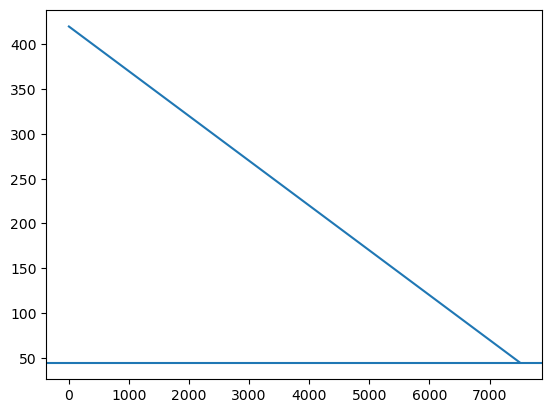

In [71]:
import math

Istop = -math.log(100/0.5-1)+50
print(Istop)

for Irand in init_Irands:
	for cool in init_cools:
		total_step = int((Irand - Istop) / cool)
		x = []
		for step in range(total_step):
			x.append(step)
		for Factor in Factors:
			for Threshold in Thresholds:
				for Patience in Patiences:
					y = []
					DD = ceil(total_step/Patience)
					for step in range(total_step):
						#y.append(45.4 + pow(Factor,floor(step/DD))*(Irand-45.4)*0.5*(math.cos(((step % DD)/DD)*3.14)+1))
						#y.append(Irand - ((Irand-45.4)/DD)*(step%DD))
						IMAX = Irand - Factor*floor(step/DD)
						y.append(IMAX - ((IMAX-Istop-Factor*(Patience-1-floor(step/DD)))/DD)*(step%DD))
					plt.plot(x,y)
plt.axhline(y=Istop)
#plt.legend()
plt.show()

IndexError: string index out of range

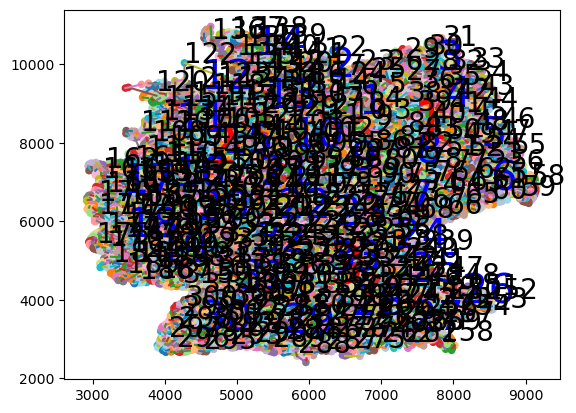

In [72]:
if True:
    route = np.array(route_btw_clusters)
    sol_route = np.array(sol_route)
    for n in range(int(len(route_btw_clusters)/2)-1):
        plt.plot(route[2*n+1:2*(n+1)+1,0], route[2*n+1:2*(n+1)+1,1], '-')
    plt.scatter(sol_route[:,0], sol_route[:,1], c=sys2_labels[n_hierarchies][:], s=20)

    colors = 'rbk'
    sol_route_ex = sol_route_ex[1:]
    for H in range(len(sol_route_ex)):
        for n in range(len(sol_route_ex[H])):
            plt.text(sol_route_ex[H][n][0],sol_route_ex[H][n][1], str(n+1), fontsize = 10*(len(sol_route_ex)-H), color = colors[H])
    plt.show()

In [ ]:
from math import sin, cos, sqrt, atan2, radians
def compute_geo(p1,p2):
    R = 6373.0
    
    lat1 = radians(float(p1[0]))
    lon1 = radians(float(p1[1]))
    lat2 = radians(float(p2[0]))
    lon2 = radians(float(p2[1]))
    
    dlon = lon2 - lon1
    dlat = lat2 -lat1

    a = sin(dlat/2)**2 + cos(lat1)*cos(lat2)*sin(dlon/2)**2
    c = 2*atan2(sqrt(a),sqrt(1-a))
    dist = R*c
    return dist

In [ ]:
coord_geo == False
if coord_geo == True:
#     test = np.load("sys2clusters_" + str(x) + "/sol_table.npy", allow_pickle=True)
    for i in range(len(test)):
        print(i)
        for j in range(len(test[i])):
            geo_dist = 0
            li = test[i][j][1]
            for idx,elem in enumerate(li):
                thiscity = elem
                nextcity = li[(idx+1)%len(li)]
                geo_dist += compute_geo(thiscity, nextcity)
            test[i][j][2] = geo_dist 
            print(geo_dist)
        np.save("sys2clusters_" + str(x) + "/sol_table" ,test)    


mport pdb; pdb.set_trace()     

In [ ]:
## Sangmin edited
GO = False
if GO:
    with open("tsp" + x + "_pyconcorde.txt", "w") as f:
        solver = TSPSolver.from_data(X_coord, Y_coord, norm="EUC_2D")  
        solution = solver.solve()
        f.write( str(" ") + str('output') + str(" ") )
        f.write( str("solution found? ") + str(solution.found_tour) + str(" ") )
        f.write( str("Optimal value? ") + str(solution.optimal_value) + str(" ") )
        f.write( str(" ").join( str(node_idx+1) for node_idx in solution.tour) )
        f.write( str(" ") + str(solution.tour[0]+1) + str(" ") )

In [ ]:
GO = False
if GO:
    num_samples = 10000
    set_nodes_coord = np.random.random([num_samples, n_clusters, 2])
    with open("tsp" + str(n_clusters) + "_pr1002.txt", "w") as f:
        solver = TSPSolver.from_data(centers[:,0], centers[:,1], norm="EUC_2D")  
        solution = solver.solve()
        f.write( " ".join( str(x)+str(" ")+str(y) for x,y in centers) )
        f.write( str(" ") + str('output') + str(" ") )
        f.write( str(" ").join( str(node_idx+1) for node_idx in solution.tour) )
        f.write( str(" ") + str(solution.tour[0]+1) + str(" ") )
        